To start, here's several helpful packages to load

In [19]:
#Useful libraries
import pandas as pd
import re
import nltk
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.metrics.pairwise import cosine_similarity
from sklearn.model_selection import train_test_split
from sklearn.metrics import mean_squared_error
from sklearn.metrics import precision_score, recall_score, f1_score, accuracy_score


In [20]:
#Importing datasets
#Books
books_file = 'datasets/books_rs/books.csv'
df_books = pd.read_csv(books_file)

#Movies
movies_file = 'datasets/books_rs/movies.csv'
df_movies = pd.read_csv(movies_file)

3. Data Preprocessing. 
Let's make the two datasets omogeneus.  First reordering.
Now we separate the ratings from the actual content, before removing the unnecessary attributes.

In [21]:
#Add a column to identify the type of content
df_books['content_type'] = 'book' 
df_movies['content_type'] = 'movie'

#Save separated ratings and content dataframes for books and movies
df_books_ratings = df_books[['Title', 'Vote Count', 'Vote Average']]
df_books_content = df_books.drop(['Vote Count', 'Vote Average'], axis=1, errors='ignore')

df_movies_ratings = df_movies[['Title', 'Vote Count', 'Vote Average']]
df_movies_content = df_movies.drop(['Vote Count', 'Vote Average'], axis=1, errors='ignore')

4. Combining Datasets. 
Merge the books and movies datasets into single DataFrames for content and ratings.


In [22]:
cross_content = pd.concat([df_books_content, df_movies_content], ignore_index=True)
cross_rating = pd.concat([df_books_ratings, df_movies_ratings], ignore_index=True)
#print("df_books_content dimensions:", df_books_content.shape)
#print("df_movies_content dimensions:", df_movies_content.shape)
#print("cross_content dimensions:", cross_content.shape)

title_type_df = cross_content[['Title', 'content_type']]

5. Processing Categories. 
Convert the 'categories' string into a list of categories for each item.

In [23]:
# Process 'categories' field into a list before creating 'tags'
def process_categories(categories_str):
    if pd.isnull(categories_str):
        return []
    
    # Check if the input is a string and parse it if needed
    if isinstance(categories_str, str):
        if categories_str.startswith('[') and categories_str.endswith(']'):
            import ast
            try:
                categories = ast.literal_eval(categories_str)
                if isinstance(categories, list):
                    return [str(cat).strip().lower() for cat in categories]
            except (ValueError, SyntaxError):
                pass
        # Use regex to split strings by common delimiters
        return [cat.strip().lower() for cat in re.split(r'[;,]', categories_str)]
    
    # If already a list, flatten it in one step
    if isinstance(categories_str, list):
        return [str(item).strip().lower() for sublist in categories_str for item in (sublist if isinstance(sublist, list) else [sublist])]
    
    return []

# Apply the optimized function
cross_content['categories_list'] = cross_content['Genres'].map(process_categories)

6. Text Preprocessing. 
a. Ensure 'categories_list' is a flat list of strings without nested lists.

In [24]:
# Use a single list comprehension to flatten categories
def flatten_categories(categories):
    return [str(item) for sublist in categories for item in (sublist if isinstance(sublist, list) else [sublist])]

# Apply the optimized function
cross_content['categories_list'] = cross_content['categories_list'].map(flatten_categories)


b. Now we condense all the non title attributes in one TAGS column.

In [25]:
# Use vectorized operations to create 'tags'
cross_content['tags'] = cross_content[['Author', 'Plot', 'content_type']].fillna('').agg('; '.join, axis=1)


c. Now we apply preprocessing to clean the tags column to remove all non essential caracteristics to clean and standardize text data for better performance.

In [26]:
# Download stop words if running for the first time!!!
if 'stopwords' not in nltk.corpus.__dict__:
    nltk.download('stopwords')

def preprocess_text(text):
    # 1. Lowercase
    text = text.lower()
    
    # 2. Remove punctuation
    text = re.sub(r'[^\w\s]', '', text)
    
    # 3. Remove stop words
    stop_words = set(stopwords.words('english'))
    words = text.split()
    words = [word for word in words if word not in stop_words]
    
    # 4. Stemming
    stemmer = PorterStemmer()
    words = [stemmer.stem(word) for word in words]
    
    # Join words back to a single string
    return ' '.join(words)

[nltk_data] Downloading package stopwords to
[nltk_data]     C:\Users\lucap\AppData\Roaming\nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


d. Combining 'tags' and 'categories_list'

In [27]:
# Preprocess 'tags' and 'categories_list'
cross_content['tags'] = cross_content['tags'].apply(preprocess_text)
cross_content['categories_list'] = cross_content['categories_list'].apply(lambda x: [preprocess_text(cat) for cat in x])

# Vectorized combination of 'tags' and 'categories_list'
cross_content['combined_tags'] = (
    cross_content['tags'] + ' ' + cross_content['categories_list'].map(' '.join)
)

e. Before splitting the data, we need to ensure that each item in cross_content has its corresponding average_rating for prediction and evaluation.

In [28]:
# Merge 'average_rating' into 'cross_content' for prediction
cross_content = cross_content.merge(cross_rating[['Title', 'Vote Average']], on='Title', how='left')

Now the cross_content dataframe is clean with a title key and a tags string rappresentative of the content. 

7. Splitting Data.
Divide the data into training and testing sets to evaluate the recommendation system.

In [29]:
# Split the dataset into training and testing sets
X_cross_train, X_cross_test = train_test_split(cross_content, test_size=0.2, random_state=42)
train_indices = X_cross_train.index
test_indices = X_cross_test.index

8. TF-IDF vectorization.
Convert textual data into numerical vectors using TF-IDF for similarity calculations.

In [30]:
tf = TfidfVectorizer(analyzer='word', ngram_range=(1, 3), min_df=0.0)
tfidf_matrix = tf.fit_transform(cross_content['tags'])

# Get TF-IDF vectors for training and test sets
train_tfidf_matrix = tfidf_matrix[train_indices]
test_tfidf_matrix = tfidf_matrix[test_indices]

9. Computing Cosine Similarities.
Calculate the similarity between each test item and all training items.

In [31]:
cosine_sim_test_train = cosine_similarity(test_tfidf_matrix, train_tfidf_matrix)

# Convert indices to numpy arrays for indexing
train_indices_array = train_indices.to_numpy()
test_indices_array = test_indices.to_numpy()

10. Evaluation Metrics.

Evaluate the performance of the recommender system using standard metrics.
    Initialize (TP), (FP), (FN), (TN).
    Loop through each test item:
    Retrieve the test item's categories, skipping items without categories.
    Compute similarity scores to all training items.
    Select top k recommended items.
    For each recommended item, check if it shares categories with the test item.
    Update TP and FP counts accordingly.
    Calculate FN and TN based on the total number of relevant and non-relevant items.
    After processing all test items, compute Precision, Recall, Accuracy, and F1 Score.

In [32]:
k = 10  # Number of similar contents to recommend

# Initialize lists to store actual and predicted ratings
actual_ratings = []
predicted_ratings = []

num_train_items = len(train_indices)
num_test_items = len(test_indices)

# Note: Total TN is typically not used in recommender systems due to the vast number of non-relevant items

for i, test_idx in enumerate(test_indices_array):
    # Get the test item
    test_item = cross_content.loc[test_idx]
    test_title = test_item['Title']
    test_actual_rating = test_item['Vote Average']
    test_categories = set(flatten_categories(test_item['categories_list']))

    # Skip items with no categories or missing ratings
    if not test_categories or pd.isnull(test_actual_rating):
        continue

    # Get the similarity scores to training items
    sim_scores = cosine_sim_test_train[i]

    # Get the top k indices in training set
    sim_scores_indices = sim_scores.argsort()[::-1]
    top_k_indices_in_train = sim_scores_indices[:k]
    top_k_train_indices = train_indices_array[top_k_indices_in_train]

    # Get similarities and ratings of the top k items
    top_k_similarities = sim_scores[top_k_indices_in_train]
    top_k_ratings = cross_content.loc[top_k_train_indices]['Vote Average'].values

    # Handle the case where similarities sum to zero
    if top_k_similarities.sum() == 0:
        predicted_rating = top_k_ratings.mean()
    else:
        # Weighted average of ratings
        predicted_rating = (top_k_similarities @ top_k_ratings) / top_k_similarities.sum()

    # Append to lists
    actual_ratings.append(test_actual_rating)
    predicted_ratings.append(predicted_rating)

    # For evaluation metrics based on categories
    # Get recommended items and their categories
    recommended_items = cross_content.loc[top_k_train_indices]
    recommended_categories = recommended_items['categories_list'].tolist()
    recommended_categories_flat = [set(flatten_categories(cats)) for cats in recommended_categories]

11. Computing metrics.
After processing all test items, we compute the overall metrics.
Precision: Proportion of recommended items that are relevant.
Recall: Proportion of relevant items that are recommended.
F1 Score: Harmonic mean of Precision and Recall.
Mean Squared Error (MSE): Measures the average squared difference between actual and predicted ratings.
Root Mean Squared Error (RMSE): Square root of MSE, providing error in the same units as the ratings.

In [33]:
#Useing sklearn to calculate metrics
threshold = 5
actual_binary = [1 if rating > threshold else 0 for rating in actual_ratings]
predicted_binary = [1 if rating > threshold else 0 for rating in predicted_ratings]

# Compute metrics
precision = precision_score(actual_binary, predicted_binary)
recall = recall_score(actual_binary, predicted_binary)
f1 = f1_score(actual_binary, predicted_binary)
accuracy = accuracy_score(actual_binary, predicted_binary)
# Compute Mean Squared Error
mse = mean_squared_error(actual_ratings, predicted_ratings)
# Compute Root Mean Squared Error
rmse = mse ** 0.5

12. Recommendation Function.

Try to find the index of the item with the specified title.
Compute cosine similarity between the item's TF-IDF vector and all items.
Sort the similarity scores in descending order.
Exclude the item itself from recommendations.
Retrieve the titles of the top k recommended items.

In [34]:
# Function to get recommendations for a content title
def get_recommendations(content_title, k):
    # Get the index of the content with the given title
    try:
        content_index = cross_content[cross_content['Title'] == content_title].index[0]
    except IndexError:
        print(f"Content titled '{content_title}' not found.")
        return []

    # Get the similarity scores for the content_index
    # Compute cosine similarity between the content and all contents
    sim_scores = cosine_similarity(tfidf_matrix[content_index], tfidf_matrix).flatten()

    # Sort the similarity scores in descending order
    sim_scores_indices = sim_scores.argsort()[::-1]

    # Get the indices of the top k+1 similar contents (excluding the content itself)
    top_indices = [i for i in sim_scores_indices if i != content_index][:k]

    # Get the titles of the recommended contents
    recommended_titles = cross_content.iloc[top_indices]['Title'].tolist()

    return recommended_titles

13. Printing Recommendations.
Generate and display recommendations for a specific content title. Sort the recommendations based on 'average_rating' and 'ratings_count' for better results


In [35]:

content_title = "The Avengers"
recommendations = get_recommendations(content_title, k)

def print_content_type(titles):
    for title in titles:
        content_type_row = title_type_df[title_type_df['Title'] == title]
        if not content_type_row.empty:
            content_type = content_type_row['content_type'].values[0]
            if content_type == 'book':
                print(f"{title} (Book)")
            elif content_type == 'movie':
                print(f"{title} (Movie)")
            else:
                print(f"{title} (Unknown Content Type)")
        else:
            print(f"{title} (Content Type Not Found)")


sorted_recommendations = cross_rating[cross_rating['Title'].isin(recommendations)].sort_values(['Vote Average', 'Vote Count'], ascending=[False, False])['Title'].tolist()
print_content_type(sorted_recommendations)


Spider-Man: Far From Home (Movie)
Extraction 2 (Movie)
Kingsman: The Golden Circle (Movie)
Heart of Stone (Movie)
Mission: Impossible III (Movie)
Sniper: G.R.I.T. - Global Response & Intelligence Team (Movie)
Night at the Museum: Secret of the Tomb (Movie)
Allegiant (Movie)
Independence Day: Resurgence (Movie)
Marvel Studios Assembled: The Making of Secret Invasion (Movie)


14. Printing validation metrics. 

Accuracy: 0.9455
Precision: 0.9509
F1 Score: 0.9719
Recall: 0.9938
Mean Squared Error: 1.6450
Root Mean Squared Error: 1.2826


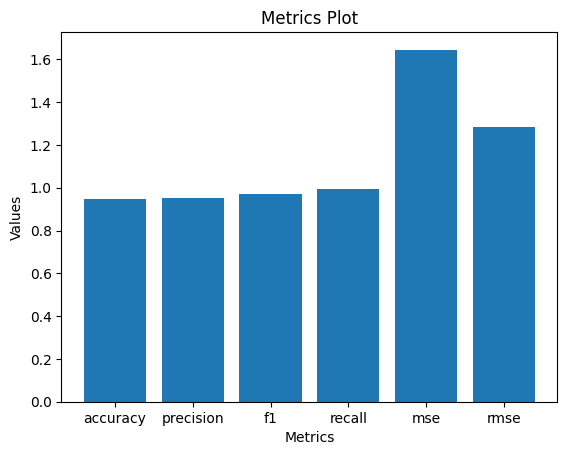

In [36]:
#Valuation of the recommender system
print(f"Accuracy: {accuracy:.4f}")
print(f"Precision: {precision:.4f}")
print(f"F1 Score: {f1:.4f}")
print(f"Recall: {recall:.4f}")
print(f"Mean Squared Error: {mse:.4f}")
print(f"Root Mean Squared Error: {rmse:.4f}")


metrics = ['accuracy', 'precision', 'f1', 'recall', 'mse', 'rmse']
values = [accuracy, precision, f1, recall, mse, rmse]

plt.bar(metrics, values)
plt.xlabel('Metrics')
plt.ylabel('Values')
plt.title('Metrics Plot')
plt.show()


